## makemore方法2：MLP
<img src="微信图片_20260209094750.png" width="40%">


In [ ]:
import torch
import torch.nn. functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# read in all the words
words = open('names.txt', 'r').read().splitlines()



### 数据集分隔

In [ ]:
# build the vocabulary of characters and mappings to/from integers
# 和bigram方法中构建一样的映射
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


# 数据集  
# 要分割成训练集、验证集、测试集（80%、10%、10%）

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print (w)
        context = [0] * block_size   # context指的是你想要推断的那个字母所依据的上文，这里设定为4，也就是根据前3个字母推断下一个字母。最开始全是0，也就是全是“.”
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)   # ix是在context后的那个字母的index
            #print(''.join(itos[i] for i in context), ' --- >', itos[ix])
            context = context[1:] + [ix] # crop and append。类似于滑动窗口，向后滑一格

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)  # 打乱列表顺序
n1= int(0.8*len(words))
n2= int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])   # 训练集
Xdev, Ydev = build_dataset(words[n1:n2]) # 验证集
Xte, Yte = build_dataset(words[n2:]) # 测试集


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### 网络架构

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g) # 嵌入矩阵，27*2，每一行是由两个数字组成的对一个字母的嵌入

# 第一层
W1 = torch.randn((6, 300), generator=g)
b1 = torch. randn(300, generator=g)
# 第二层
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # number of parameters in total

10281

### 调整学习率

In [ ]:

lre = torch.linspace(-3, 0, 1000) # 设置不同的学习率，看哪个学习率好。指数间隔。
lrs = 10 ** lre

### 训练

In [ ]:
lri = []
lossi = []
stepi = []


for i in range(10000):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # 生成一个一维张量，包含32个从0到Xtr.shape[0]（也就是Xtr中三元字母组合的数量）中的序号。本质上意思就是每次抽取32个拿来训练

    # 正向传播
    emb = C[Xtr[ix]] # 嵌入层，通过索引查询到Xtr这个张量中每个元素的嵌入。emb的形状torch.Size([32, 3, 2])，32是一个batch中三元字母组的数量，3是三元字母的意思，2是字母的embedding用几个数表示
    h= torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)   # emb.view(-1,6)这种方法能更好地转换形状，效率高于cat，因为它直接转换内存管理的方式。-1这个参数表示让torch自己推断这一维的数。torch.cat(torch.unbind(emb, 1),1) 同样可以有相同的效果，unbind去除emb的第二个维度，变成3个torch.Size([32, 2])的tensor组成的tuple，之后再沿第二维concatenate，变成32*6，方便与权重相乘。同样相当于torch.cat([emb[:, 0,:], emb[:, 1,:], emb[:, 2,:]], 1).shape，这个就不用再显式地写出第二维的数量
    logits = h @ W2 + b2 # (32, 27) ，27取决于最后输出的参数，原则上对应于27个字母符号
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Ytr[ix]].log().mean()   # 这几行构建loss的方法和bigram里面一样
    loss = F.cross_entropy(logits,Ytr[ix],reduction='mean') # 上面注释中的三行可以合并写为交叉熵损失，计算更高效。默认reduction是meaning，也就是计算出来的结果会取均值

    # 反向传播
    for p in parameters:
        p.grad = None
    loss.backward()

    # 更新权重
    # lr = lrs[i]
    lr = 0.1 # 经过试验，发现取0.1比较好
    for p in parameters:
        p.data += -lr * p.grad

    # # 记录不同学习率时loss的变化
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)

print(loss.item())



2.402568817138672


### 训练过程可视化

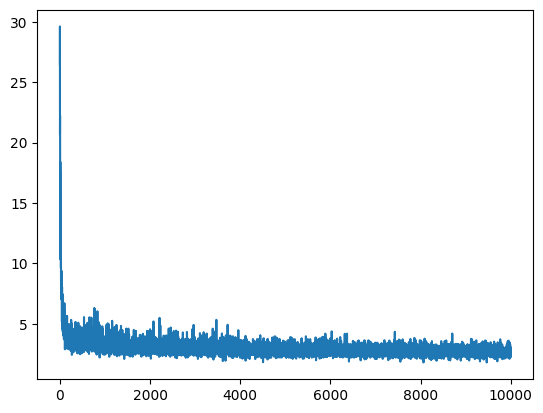

In [ ]:
# 用来显示训练过程中loss随学习率的变化
# plt.plot(lri,lossi)

# 展示训练中loss的随步数的变化
plt.plot(stepi,lossi)
plt.show()

# 结果显示lr在10**-1的地方比较好

### 验证

In [ ]:
# 验证
emb = C[Xdev] 
h= torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits,Ydev,reduction='mean') 
loss

tensor(2.5402, grad_fn=<NllLossBackward0>)

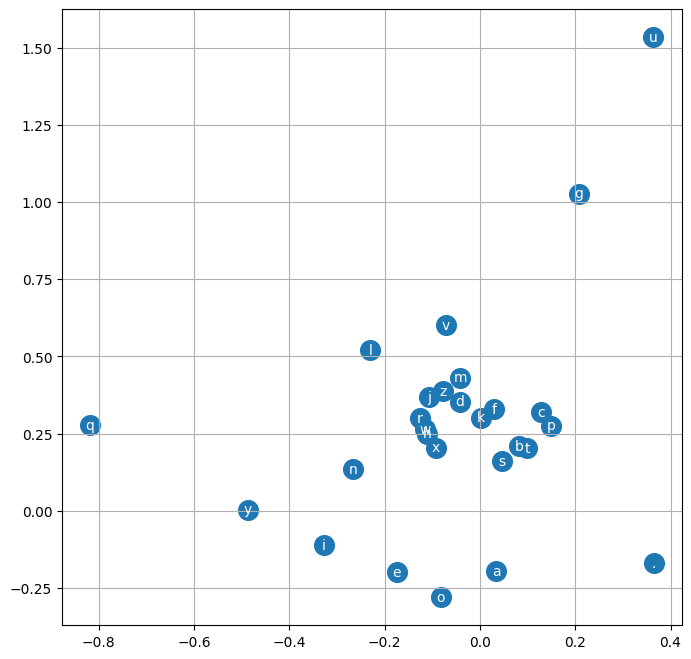

In [ ]:
# 因为嵌入层设置是二维的，所以这里我们可以可视化看一下
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

### 生成

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)  
        h= torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

NameError: name 'torch' is not defined